In [1]:
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sys.path.append('../../modules')
from ar_scale import calc_ar_scale

In [2]:
path_to_figs = '../../figs/'

In [3]:
## SWE data manually copied and pasted from another notebook
# prec = np.array([0.5, 0. , 0.1, 1.1, 0.6, 1.8, 0. ]) # SWE
# prec = np.array([0.2, 0.6, 1.8, 0.7, 0. ])
# ## TOWER COORDS
# y = 40.540000
# x = -106.680000

In [4]:
start_date='2022-12-30'
end_date='2023-01-03'

## UPPER YAMPA CENTROID
y = 40.45357198
x = -107.13236378

dates = pd.date_range(start=start_date, end=end_date, freq='1D')
# put into pandas df
d ={"date": dates}
df = pd.DataFrame(data=d)
df['day']= df['date'].dt.day.map("{:02}".format)
df['month']= df['date'].dt.month.map("{:02}".format)
df['year']= df['date'].dt.year

# create list of daily ERA5 files for each AR
filenames = []
for j, row in df.iterrows():
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/{0}/ERA5_IVT_{0}{1}{2}.nc'.format(row['year'], row['month'], row['day']))
    # open all files within the AR period

era = xr.open_mfdataset(filenames, combine='by_coords', parallel=False)

ds = era.sel(lat=y, lon=x, method='nearest')
df = ds.to_dataframe()
df

,IVT,lat,lon,uIVT,vIVT,IWV
time,,,,,,
2022-12-30 00:00:00,26.887420,40.5,-107.25,26.364859,5.275182,2.918492
2022-12-30 01:00:00,27.684375,40.5,-107.25,27.463105,3.493212,2.849100
2022-12-30 02:00:00,27.114365,40.5,-107.25,26.835536,3.878502,2.799047
2022-12-30 03:00:00,25.151741,40.5,-107.25,24.795937,4.215632,2.726242
2022-12-30 04:00:00,24.732481,40.5,-107.25,24.272963,4.745407,2.676189
...,...,...,...,...,...,...
2023-01-03 19:00:00,38.580000,40.5,-107.25,38.579903,-0.086300,4.588268
2023-01-03 20:00:00,39.518222,40.5,-107.25,39.508457,-0.878446,4.590638
2023-01-03 21:00:00,40.575161,40.5,-107.25,40.534753,-1.810382,4.616707


In [5]:
### Get x-tick and x-labels for both cases
x1 = df.index.values

x_lst = [x1]
xlbl_lst = []
xtick_lst = []
for i, x in enumerate(x_lst):
    x_lbl = []
    xtick_lst.append(x)
    for j in range(len(x)):
        t = pd.to_datetime(str(x[j]))
        x_lbl.append(t.strftime('%m-%d-%Y'))
    xlbl_lst.append(x_lbl)

In [6]:
df = df.reset_index()
df = df.rename(columns={"time": "date"})
ar_scale = calc_ar_scale(df)
ar_scale

,start_date,end_date,duration,max_IVT,AR_scale


In [7]:
import numpy as np


In [8]:
## get PRISM precip data
fname = '/data/projects/Comet/cwp140/preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)

## select Upper Yampa watershed
HUC8 = '14050001'
PRISM = PRISM.sel(HUC8=HUC8)

## select dates from event
PRISM = PRISM.sel(date=slice(start_date, end_date))
PRISM

<xarray.Dataset>
Dimensions:  (date: 5)
Coordinates:
  * date     (date) datetime64[ns] 2022-12-30 2022-12-31 ... 2023-01-03
    HUC8     <U8 '14050001'
Data variables:
    prec     (date) float64 ...
    extreme  (date) int64 ...
    lat      float64 ...
    lon      float64 ...

In [9]:
prec = PRISM.prec.values

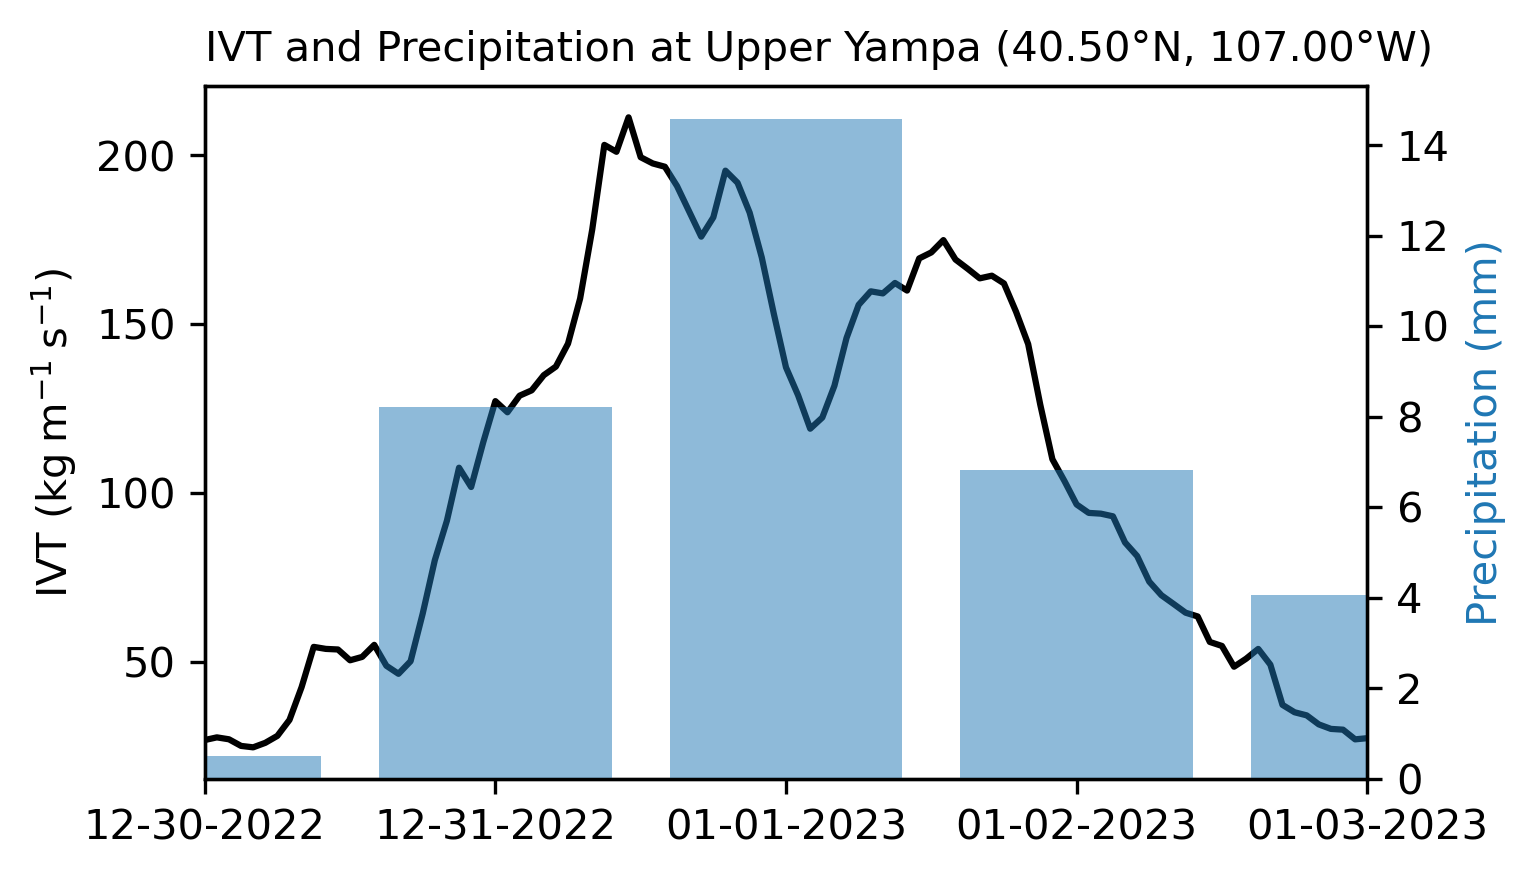

In [10]:
fname = path_to_figs + 'ar_tseries_dec2022'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((5.0,3.0))
fig.dpi = 300

ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, df.IVT.values, color='k')
ax.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10.)
ax.set_xlim(x1.min(), x1[-24])
lbl = u"IVT and Precipitation at Upper Yampa ({:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W)".format(40.5, 107.0)
ax.set_title(lbl, loc='left',fontsize=10)

## x-axis format dates/ticks
x_ticks = xtick_lst[0]
x_labels = xlbl_lst[0]
ax.set_xticks(x_ticks[::24]) # set the labels every x hours
ax.set_xticklabels(x_labels[::24], fontsize=10)

# highlight a time range
for index, row in ar_scale.iterrows():
    if row['AR_scale'] == 1:
        c = (10./255.0, 193./255.0, 255./255.0) #10, 193, 255
    elif row['AR_scale'] == 2:
        c = (4./255.0, 255./255.0, 3./255.0) #4, 255, 3
    elif row['AR_scale'] == 3:
        c = (255./255.0, 255./255.0, 3./255.0) #255, 255, 3
    elif row['AR_scale'] == 4:
        c = (255./255.0, 166./255.0, 2./255.0) #255, 166, 2
    elif row['AR_scale'] == 5:
        c = (255./255.0, 1./255.0, 0./255.0) #255, 1, 0
        

    ax.axvspan(row['start_date'], row['end_date'], color=c, alpha=0.3)
    
## add twin axis for SWE
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(x1[::24], prec, color='tab:blue', alpha=0.5, zorder=0)
ax2.set_ylabel('Precipitation (mm)', fontsize=10., color='tab:blue')    
    
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()

In [14]:
df.IVT

0      26.876164
1      25.081205
2      24.776611
3      23.085569
4      22.262230
         ...    
115    37.316367
116    37.824891
117    38.446498
118    36.571417
119    37.116563
Name: IVT, Length: 120, dtype: float64

In [8]:
df.IVT.values

array([ 32.9570052 ,  39.31172398,  43.18045127,  45.52252215,
        49.53486018,  53.52981413,  55.7007983 ,  58.76627041,
        63.54572153,  67.46431939,  66.91353242,  68.84309071,
        70.41630837,  70.25283118,  68.1530715 ,  70.33132196,
        74.08784821,  78.67454818,  82.8599862 ,  85.97003225,
        88.33783598,  89.33401265,  90.37354886,  89.47404073,
        87.14020751,  79.72979867,  72.18578158,  64.83403781,
        55.53655274,  47.85716743,  41.73982472,  36.96207945,
        35.27764956,  34.67660784,  38.54162361,  40.15337502,
        40.96158086,  42.03928364,  41.60587217,  40.57452943,
        42.93213719,  47.8184367 ,  50.23026559,  53.39858134,
        60.01423305,  75.52228639,  90.38386204,  96.31681107,
        91.52654414,  80.262958  ,  64.6997261 ,  58.48895472,
        54.30749292,  59.84364557,  56.66157505,  59.59358176,
        69.50207298,  79.49095433, 103.99336655, 120.60253909,
       129.44854182, 127.96867602, 122.94138616, 123.66